In [2]:
# !pip install tensorflow
# !pip install keras

In [1]:
from multiprocessing import Pool, cpu_count

In [2]:
import keras
import matplotlib.pyplot as plt 
import numpy as np

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate

from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import src.zeldovich as Z

# from keras_unet.models import custom_unet
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dropout

%matplotlib inline

2023-09-28 19:31:32.736437: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-28 19:31:33.765128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-09-28 19:31:45.985545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 19:31:46.442361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 19:31:46.442663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
## Random seed for producing the same results
np.random.seed(987)
tf.random.set_seed(987)

In [5]:
# Set the parameters
Lbox = 256.0  # Size of the simulation box
Ngrid = 32  # Grid size
pkfile = 'colossus_generated_data/pk_indra7313.txt'  # File path for the power spectrum

# Load power spectrum from txt file
pkinit = np.loadtxt(pkfile)

num_simulations = 5000

In [6]:
# Run several simulations and store initial states and final states

def simulation(_):
    ic = np.random.normal(0., 1., (Ngrid, Ngrid, Ngrid))
    final_density, initial_conditions = Z.run_wn(0., ic, pkinit, boxsize=Lbox, ngrid=Ngrid)
    return (initial_conditions, final_density)

with Pool(cpu_count()) as p:
    data = list(tqdm(p.imap(simulation, range(num_simulations), chunksize=1), total=num_simulations))

100%|██████████| 5000/5000 [02:37<00:00, 31.70it/s]


In [7]:
# Convert the list into numpy array for easy data handling
data = np.array(data)

# Split the data
initial_state = data[:, 0]
final_state = data[:, 1]

# Compute the mean and std of the initial and final states
initial_state_mean, initial_state_std = np.mean(initial_state), np.std(initial_state)
final_state_mean, final_state_std = np.mean(final_state), np.std(final_state)

# Normalize the initial and final states
initial_state = (initial_state - initial_state_mean) / initial_state_std
final_state = (final_state - final_state_mean) / final_state_std

# Select one simulation's initial and final states
initial_conditions = initial_state[0]
final_density = final_state[0]

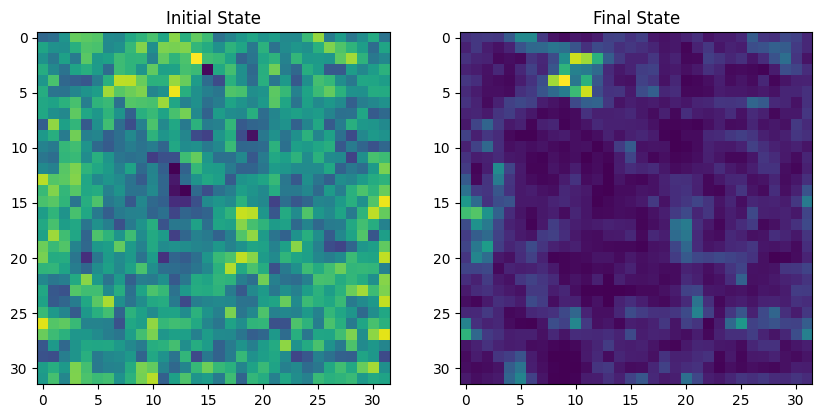

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# initial state and final state
axes[0].imshow(initial_conditions[0], cmap='viridis')
axes[0].set_title("Initial State")

axes[1].imshow(final_density[0], cmap='viridis')  
axes[1].set_title("Final State")

plt.show()

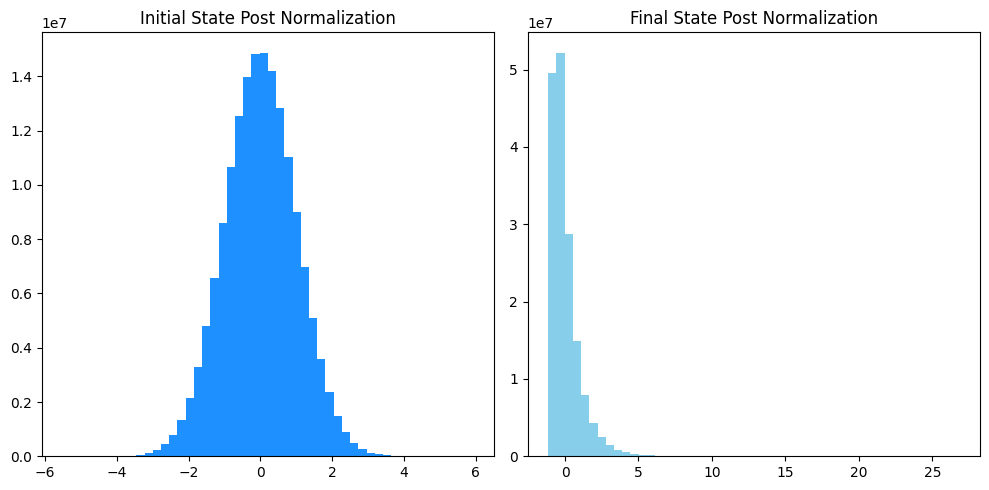

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histograms
axs[0].hist(initial_state.flatten(), bins=50, color='dodgerblue')
axs[0].set_title('Initial State Post Normalization')
axs[1].hist(final_state.flatten(), bins=50, color='skyblue')
axs[1].set_title('Final State Post Normalization')

plt.tight_layout()
plt.show()

In [10]:
# train and test
X_train, X_test, y_train, y_test  = train_test_split(initial_state, final_state, test_size=0.2, random_state=314159)

# further splitting it in training and testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=314159)

In [11]:
# Recasting dimensions to 4D tensor (suitable for 3D convolutions) with the following dimensions: 
# (batch_size, height, width, depth, num_channels)
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

y_train = np.reshape(y_train, (*y_train.shape, 1))
y_val = np.reshape(y_val, (*y_val.shape, 1))
y_test = np.reshape(y_test, (*y_test.shape, 1))

In [12]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape, y_test.shape

((3600, 32, 32, 32, 1),
 (400, 32, 32, 32, 1),
 (3600, 32, 32, 32, 1),
 (400, 32, 32, 32, 1),
 (1000, 32, 32, 32, 1),
 (1000, 32, 32, 32, 1))

In [13]:
def create_volumetric_unet(input_shape, num_classes):
    # input layer
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(drop1)
    
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(drop2)

    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv3)

    # Expansive path
    up1 = Concatenate()([UpSampling3D(size=(2, 2, 2))(conv3), conv2])
    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up1)
    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4)

    up2 = Concatenate()([UpSampling3D(size=(2, 2, 2))(conv4), conv1])
    conv5 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up2)
    conv5 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv5)

    # Final conv layer to reduce channel dimensionality to number of classes
    conv_final = Conv3D(num_classes, (1, 1, 1))(conv5)

    return Model(inputs=[inputs], outputs=[conv_final])

In [14]:
Ngrid = 32  
unet_model = create_volumetric_unet((Ngrid, Ngrid, Ngrid, 1), num_classes=1)

2023-09-28 19:34:36.996123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 19:34:36.996460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 19:34:36.996654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [15]:
unet_model.compile(optimizer='adam', 
             loss='mean_squared_error',
             run_eagerly=True)

In [16]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [19]:
# Train the model
history = unet_model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64, 
                    epochs=50,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50


2023-09-27 19:17:12.383112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-09-27 19:17:30.677496: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-27 19:17:30.680271: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-09-27 19:17:32.378034: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were ava

 1/57 [..............................] - ETA: 43:26 - loss: 1.0002

2023-09-27 19:18:06.803230: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-27 19:18:08.781403: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


57/57 [==============================] - ETA: 0s - loss: 3.1501
Epoch 1: loss improved from inf to 3.15012, saving model to unet.hdf5
57/57 [==============================] - 269s 4s/step - loss: 3.1501 - val_loss: 0.6325 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 0.5920
Epoch 2: loss improved from 3.15012 to 0.59203, saving model to unet.hdf5
57/57 [==============================] - 184s 3s/step - loss: 0.5920 - val_loss: 0.5575 - lr: 0.0010
Epoch 3/50
57/57 [==============================] - ETA: 0s - loss: 0.5264
Epoch 3: loss improved from 0.59203 to 0.52635, saving model to unet.hdf5
57/57 [==============================] - 171s 3s/step - loss: 0.5264 - val_loss: 0.5039 - lr: 0.0010
Epoch 4/50
57/57 [==============================] - ETA: 0s - loss: 0.4879
Epoch 4: loss improved from 0.52635 to 0.48788, saving model to unet.hdf5
57/57 [==============================] - 173s 3s/step - loss: 0.4879 - val_loss: 0.4841 - lr: 0.0010
Epoch 5/50
57/5

In [17]:
from tensorflow.keras.models import load_model

# Load the model
unet_model = load_model('unet.hdf5')

In [18]:


# Continue training
history = unet_model.fit(x=X_train,
                         y=y_train,
                         validation_data=(X_val, y_val),
                         batch_size=64, 
                         epochs=50,  # or however many epochs you want to train
                         callbacks=[early_stopping, reduce_lr, model_checkpoint],
                         initial_epoch=38)  # start from the epoch where it stopped

Epoch 39/50


2023-09-28 05:12:32.578362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-09-28 05:12:47.476212: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2fe76d42b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-28 05:12:47.476291: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-28 05:12:47.633394: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-28 05:12:48.356733: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - ETA: 0s - loss: 0.1579
Epoch 39: loss improved from inf to 0.15786, saving model to unet.hdf5
57/57 [==============================] - 253s 4s/step - loss: 0.1579 - val_loss: 0.2629 - lr: 0.0010
Epoch 40/50
57/57 [==============================] - ETA: 0s - loss: 0.1556
Epoch 40: loss improved from 0.15786 to 0.15557, saving model to unet.hdf5
57/57 [==============================] - 171s 3s/step - loss: 0.1556 - val_loss: 0.2612 - lr: 0.0010
Epoch 41/50
57/57 [==============================] - ETA: 0s - loss: 0.1537
Epoch 41: loss improved from 0.15557 to 0.15373, saving model to unet.hdf5
57/57 [==============================] - 177s 3s/step - loss: 0.1537 - val_loss: 0.2680 - lr: 0.0010
Epoch 42/50
57/57 [==============================] - ETA: 0s - loss: 0.1516
Epoch 42: loss improved from 0.15373 to 0.15162, saving model to unet.hdf5
57/57 [==============================] - 178s 3s/step - loss: 0.1516 - val_loss: 0.2608 - lr: 0.0010
Epoch 43

In [18]:
# Evaluate the model
eval_results = unet_model.evaluate(x=X_test, y=y_test)
print(f"Evaluation Results:{eval_results}")

2023-09-28 19:34:45.135897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800


32/32 [==============================] - 35s 689ms/step - loss: 0.2580
Evaluation Results:0.25799232721328735


In [19]:
# Predict with the model
predictions = unet_model.predict(X_test)
predictions.shape

32/32 [==============================] - 16s 524ms/step


(1000, 32, 32, 32, 1)

In [20]:
vmin = min(np.min(predictions), np.min(X_test))
vmax = max(np.max(predictions), np.max(X_test))

vmin, vmax

(-5.5221084950188155, 19.938929)

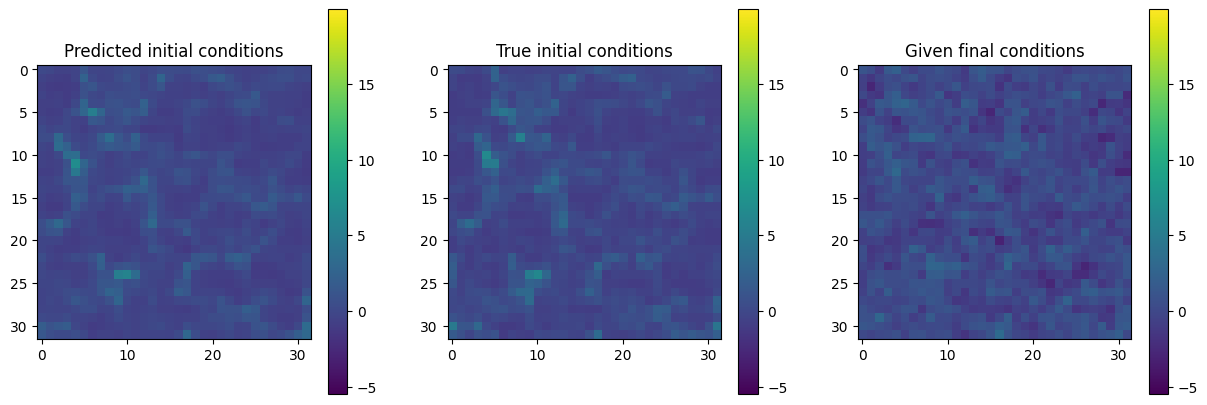

In [21]:
test_index = 0

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot predicted initial conditions
im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[:,:,Ngrid//2], vmin=vmin, vmax=vmax)
axs[0].set_title('Predicted initial conditions')
fig.colorbar(im, ax=axs[0])

# Plot true final conditions
im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[:,:,Ngrid//2], vmin=vmin, vmax=vmax)
axs[1].set_title('True initial conditions')
fig.colorbar(im, ax=axs[1])

# Plot initial conditions 
im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[:,:,Ngrid//2], vmin=vmin, vmax=vmax)
axs[2].set_title('Given final conditions')
fig.colorbar(im, ax=axs[2])

plt.show()

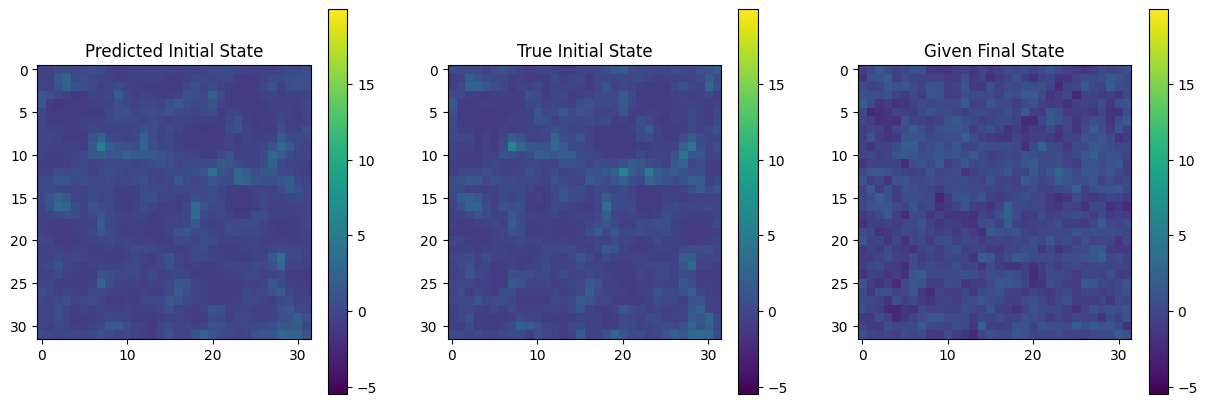

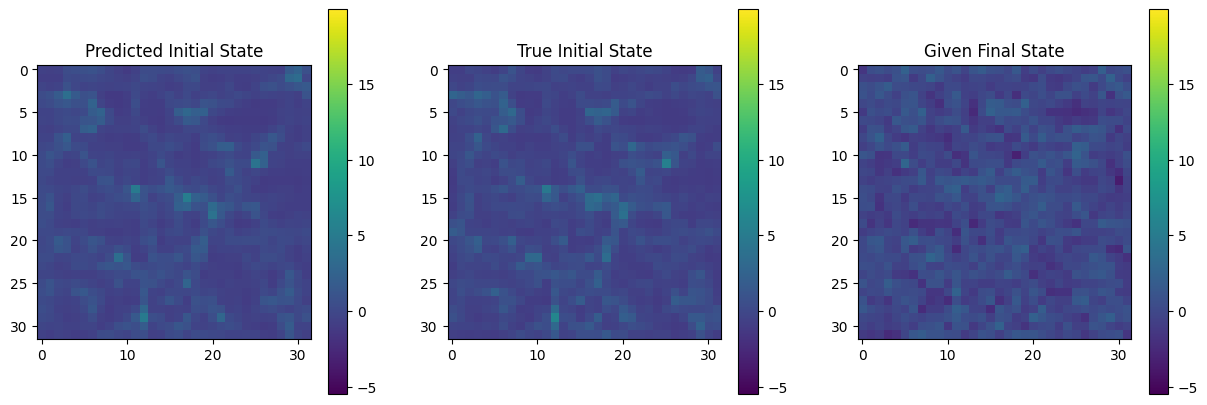

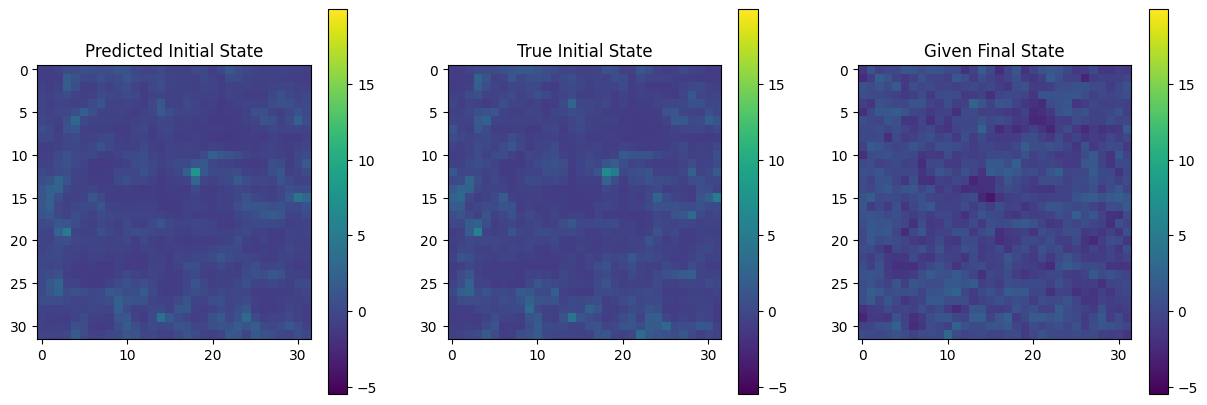

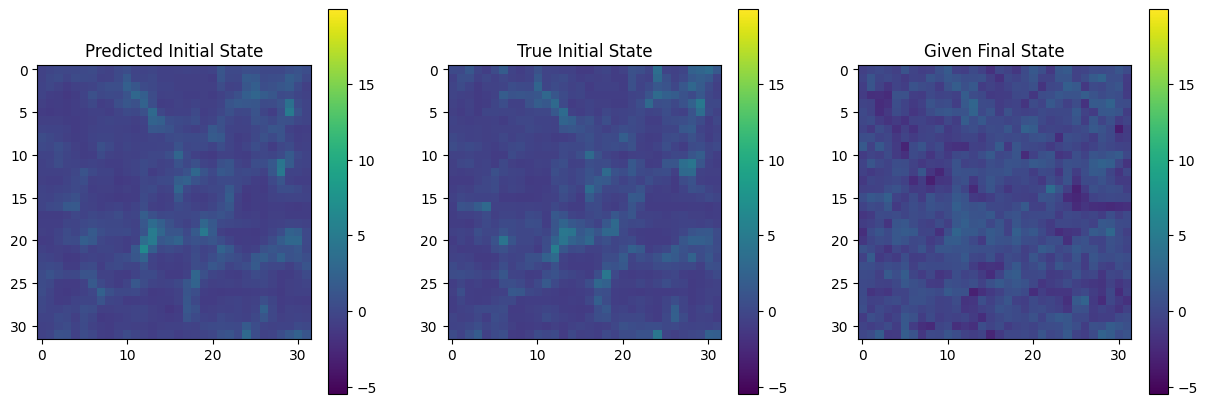

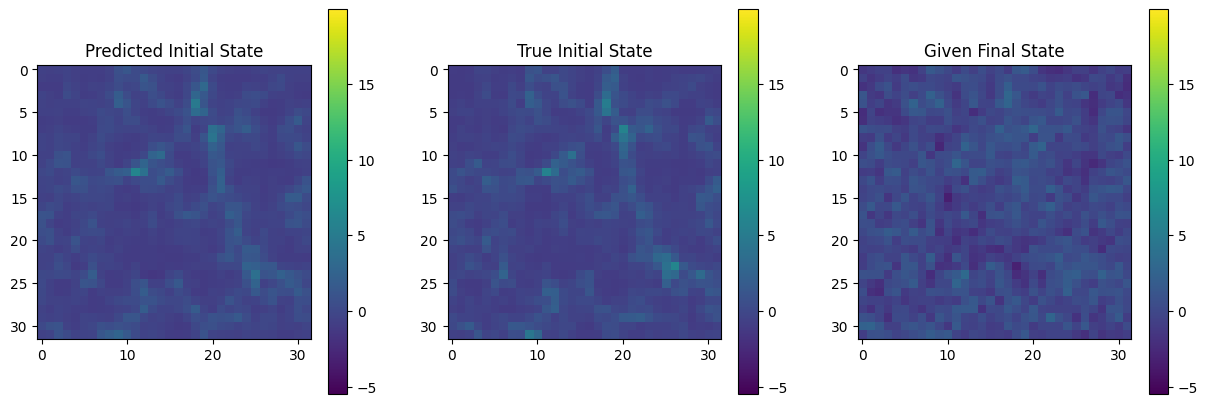

In [22]:
for test_index in range(5):  # Plot first 5 test cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot predicted initial state
    im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # Plot true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # Plot given final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

In [23]:
# calculating the error metrics
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.2579923425686112
Mean Absolute Error (MAE): 0.3350037565523251


In [24]:
y_test.shape, predictions.shape

((1000, 32, 32, 32, 1), (1000, 32, 32, 32, 1))

In [25]:
# saved and load this data to get the plot created below. Was needed to avoid kernel restarting.

# Save the arrays to .npy files
# np.save('y_test.npy', y_test)
# np.save('predictions.npy', predictions)

# Load the arrays from .npy files
# y_test = np.load('y_test.npy')
# predictions = np.load('predictions.npy')

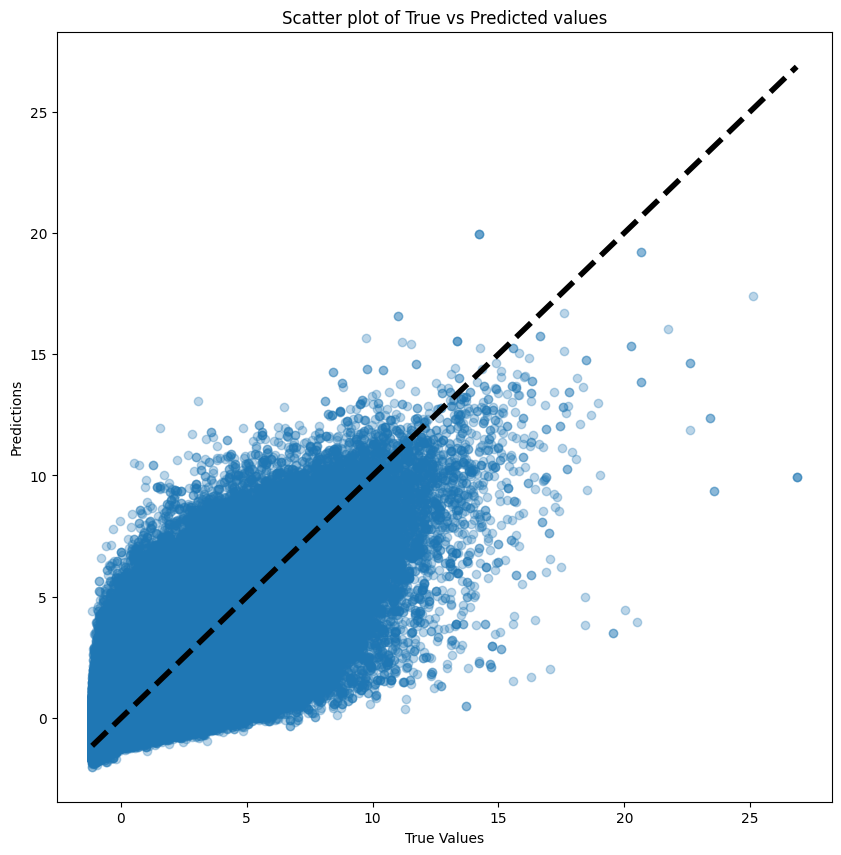

In [6]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter plot of True vs Predicted values')
plt.show()

# script complete